In [10]:
import batman
import numpy as np
import matplotlib.pyplot as plt

params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

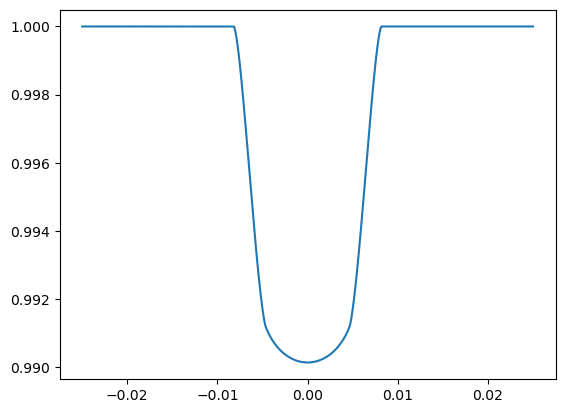

In [11]:
flux = m.light_curve(params)
plt.plot(t, flux)

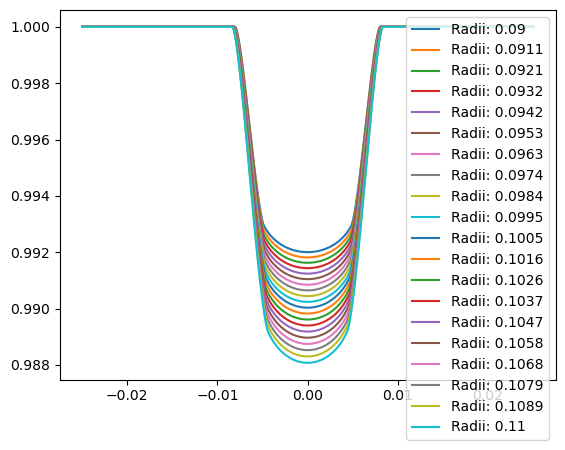

In [12]:
plt.figure()
radii = np.linspace(0.09, 0.11, 20)
for r in radii:
        params.rp = r                           #updates planet radius
        new_flux = m.light_curve(params)        #recalculates light curve
        plt.plot(t, new_flux, label='Radii: '+str(round(r,4)))
plt.legend()

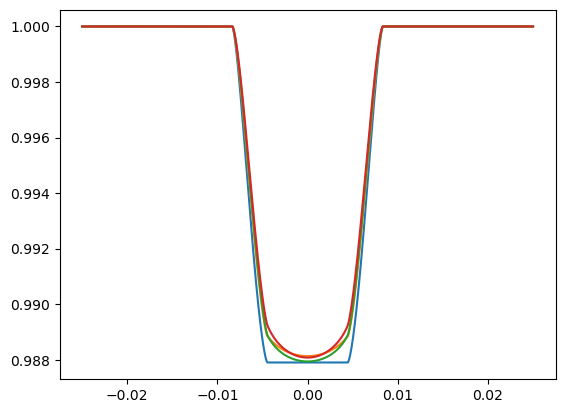

In [13]:
ld_options = ["uniform", "linear", "quadratic", "nonlinear"]
ld_coefficients = [[], [0.3], [0.1, 0.3], [0.5, 0.1, 0.1, -0.1]]

plt.figure()

for i in range(4):
        params.limb_dark = ld_options[i]          #specifies the LD profile
        params.u = ld_coefficients[i]             #updates LD coefficients
        m = batman.TransitModel(params, t)        #initializes the model
        flux = m.light_curve(params)              #calculates light curve
        plt.plot(t, flux, label = ld_options[i])

In [170]:
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from lightkurve.periodogram import BoxLeastSquaresPeriodogram
from lightkurve import LightCurveCollection
import matplotlib.pyplot as plt
from astropy import units as u
from lightkurve import search_lightcurve
import numpy as np
from pathlib import Path
import shutil
import glob
import pandas as pd
import os
import gc
from astropy.io import fits
import batman
from iminuit import Minuit

fits.Conf.use_memmap = False 

In [171]:
planet = "Kepler-10 b"

def sanitize_name(name: str) -> str:
    import re
    s = re.sub(r"[^\w\-_\. ]", "_", name).strip()
    return s.replace(" ", "_")

planet_sanitized = sanitize_name(planet)
outdir = Path(f"./{planet_sanitized}")
outdir.mkdir(parents=True, exist_ok=True)
print(f"Çıktılar {outdir} içine kaydedilecek.")

# NASA Exoplanet Archive'den gezegen bilgisi çekme
tbl = NasaExoplanetArchive.query_criteria(
    table="pscomppars",
    select="pl_name,hostname,pl_orbper,pl_tranmid",
    where=f"pl_name='{planet}'"
)
if len(tbl) == 0:
    raise RuntimeError(f"{planet} bulunamadı. İsim formatını kontrol et!")

P_catalog = tbl["pl_orbper"][0].to_value("d")  # birimi 'd' (gün) olarak çıkar
host = str(tbl["hostname"][0])
print(f"{planet} için katalog periyodu: {P_catalog} gün, host: {host}")


Çıktılar Kepler-10_b içine kaydedilecek.
Kepler-10 b için katalog periyodu: 0.8374907 gün, host: Kepler-10


In [172]:
tpf = lk.search_targetpixelfile(planet, author= "Kepler", cadence="long").download_all(quality_bitmask='default', download_dir=str(outdir))
print("TPF kaydedildi:")
print("İndirilen TPF sayısı:", len(tpf))

TPF kaydedildi:
İndirilen TPF sayısı: 15


In [173]:
lc_collection = []

for i, t in enumerate(tpf):

    lc = t.to_lightcurve(aperture_mask=t.pipeline_mask).flatten(window_length=101).remove_nans().remove_outliers(sigma_lower=float('inf'), sigma_upper=3)
    lc_collection.append(lc)
    print(f"lc_{i} oluşturuldu ve lc_collection'a eklendi.")

lc_0 oluşturuldu ve lc_collection'a eklendi.
lc_1 oluşturuldu ve lc_collection'a eklendi.
lc_2 oluşturuldu ve lc_collection'a eklendi.
lc_3 oluşturuldu ve lc_collection'a eklendi.
lc_4 oluşturuldu ve lc_collection'a eklendi.
lc_5 oluşturuldu ve lc_collection'a eklendi.
lc_6 oluşturuldu ve lc_collection'a eklendi.
lc_7 oluşturuldu ve lc_collection'a eklendi.
lc_8 oluşturuldu ve lc_collection'a eklendi.
lc_9 oluşturuldu ve lc_collection'a eklendi.
lc_10 oluşturuldu ve lc_collection'a eklendi.
lc_11 oluşturuldu ve lc_collection'a eklendi.
lc_12 oluşturuldu ve lc_collection'a eklendi.
lc_13 oluşturuldu ve lc_collection'a eklendi.
lc_14 oluşturuldu ve lc_collection'a eklendi.


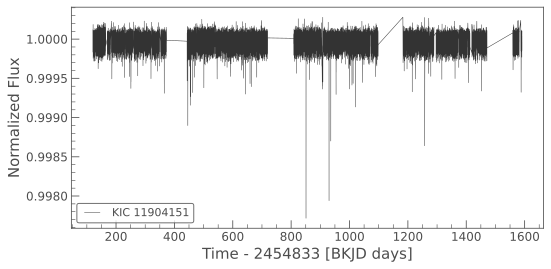

In [174]:
lc_collection = LightCurveCollection(lc_collection)
lc_stitched = lc_collection.stitch()
lc_stitched.plot()
plt.show()

In [175]:
frequency_factor=500
min_period, max_period = 0.5, (((lc_stitched.time[-1].value - lc_stitched.time[0].value) / 3))
duration = [0.05, 0.10, 0.15, 0.20, 0.25, 0.33]
df = (frequency_factor * np.min(duration) / (np.max(lc_stitched.time.value) - np.min(lc_stitched.time.value)) ** 2)
npoints = int(((1 / min_period) - (1 / max_period)) / df)

print(frequency_factor)
print(min_period, max_period)
print(df, npoints)

500
0.5 490.1541774544797
1.1561976504612817e-05 172804


`period` contains 172804 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


BLS ile bulunan periyot: 0.83749 d


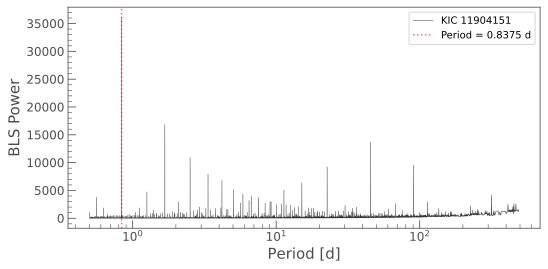

In [176]:
bls = lc_stitched.to_periodogram(method="bls", minimum_period=min_period, maximum_period=max_period, frequency_factor=frequency_factor)
bls.plot()
bls_period = bls.period_at_max_power.value
print(f"BLS ile bulunan periyot: {bls_period:.5f} d")
plt.savefig("bls_periodogram.png", dpi=300)
plt.semilogx()
#plt.loglog()
plt.axvline(bls_period, color='r', linestyle='dotted', label=f"Period = {bls_period:.4f} d", alpha=0.6)
plt.legend()
plt.show()

In [177]:
planet_1_period = bls.period_at_max_power
planet_1_t0 = bls.transit_time_at_max_power
planet_1_dur = bls.duration_at_max_power

print("P   : ", planet_1_period)
print("T0  : ", planet_1_t0)
print("Dur : ", planet_1_dur)

P   :  0.837494465190634 d
T0  :  120.6891465105713
Dur :  0.1 d


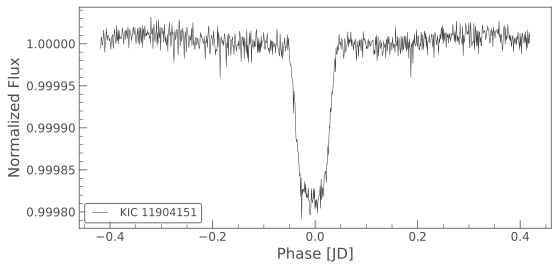

In [178]:
folded_lc = lc_stitched.fold(period=planet_1_period, epoch_time=planet_1_t0).bin(time_bin_size=0.001)#.scatter()
folded_lc.plot();
plt.show()

In [324]:
df = folded_lc.to_table().to_pandas()
csv_path = os.path.join(outdir, "folded_lightcurve_kepler.csv")
df.to_csv(csv_path, index=False)

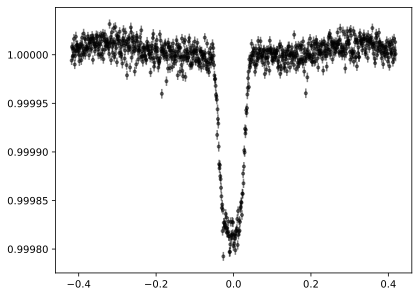

In [340]:
df_kepler = pd.read_csv("D:\\Kodlar\\Kepler-10_b\\folded_lightcurve_kepler.csv")

df_kepler["time"] = pd.to_timedelta(df_kepler["time"])
phase = df_kepler["time"].dt.total_seconds().values / 86400  # zaman (gün)

flux = df_kepler["flux"].astype(float).values
flux_err = df_kepler["flux_err"].astype(float).values
t0 = 2454964.57375
t_norm = phase - t0
plt.errorbar(phase, flux, yerr=flux_err, fmt='.', color="black", alpha=0.5, label='Kepler Data')
plt.show()

In [341]:
def transit_model(phase, rp, a, inc):
    params = batman.TransitParams()
    params.t0 = 0.
    params.per = 0.8375  # Kepler-10b için değer
    params.rp = rp
    params.a = a
    params.inc = inc
    params.ecc = 0.
    params.w = 90.
    #params.limb_dark = "quadratic"
    #params.u = [0.3, 0.1] 
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]
    
    m = batman.TransitModel(params, phase, fac=0.025) 
    return m.light_curve(params)

In [342]:
def chi2(rp, a, inc):
    model = transit_model(phase, rp, a, inc)
    return np.sum(((flux - model) / flux_err) ** 2)

In [343]:
def get_chi2(phase, flux, flux_err):
    def chi2(rp, a, inc):
        model = transit_model(phase, rp, a, inc)
        return np.sum(((flux - model) / flux_err) ** 2)
    return chi2

chi2_func = get_chi2(phase, flux, flux_err)
m = Minuit(chi2_func, rp=0.01, a=15, inc=87)

In [344]:
m = Minuit(chi2, rp=0.01, a=15, inc=87)
m.errordef = Minuit.LEAST_SQUARES

# Burada parametrelere alt ve üst limitler koyabilirsin.
# Mesela 'rp' veya 'a' değerlerinin negatif olmasını istemeyiz.
m.limits["rp"] = (0, 1)
m.limits["a"]  = (0, 1000)
m.limits["inc"] = (0, 360)
m.migrad()
m.hesse()

print("Best-fit:", m.values)
print("Errors:", m.errors)

Best-fit: <ValueView rp=0.01600498366161307 a=1.2182694359442192 inc=143.701534146308>
Errors: <ErrorView rp=4.5138499662089604e-05 a=0.0015811748761140887 inc=0.11225723150201361>


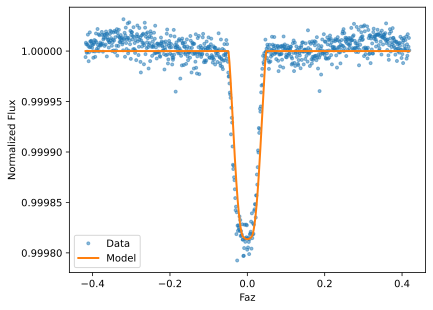

In [345]:
model_best = transit_model(phase, *m.values)
plt.plot(phase, flux, '.', alpha=0.5, label="Data")
plt.plot(phase, model_best, '-', lw=2, label="Model")
plt.xlabel("Faz")
plt.ylabel("Normalized Flux")
plt.legend()


In [346]:
best_model = transit_model(phase, *m.values)

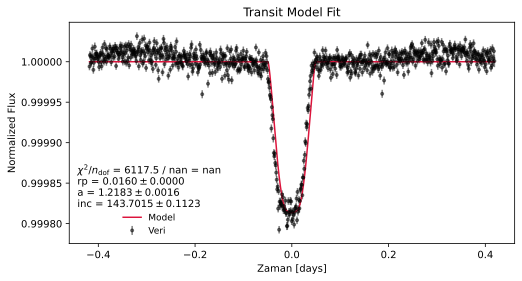

In [347]:
plt.figure(figsize=(8, 4))
plt.errorbar(phase, flux, yerr=flux_err, fmt='.', color="black", alpha=0.5, label='Veri')
plt.plot(phase, best_model, color='crimson', label='Model')

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.4f} \\pm {e:.4f}$")

plt.legend(title="\n".join(fit_info), frameon=False, fontsize=9)

plt.xlabel("Zaman [days]")
plt.ylabel("Normalized Flux")
plt.title("Transit Model Fit")
plt.show()

In [321]:
m.covariance

,rp,a,inc
rp,2.04e-09,-17.1e-9 (-0.240),1.6065e-6 (0.317)
a,-17.1e-9 (-0.240),2.5e-06,-176.5e-6 (-0.994)
inc,1.6065e-6 (0.317),-176.5e-6 (-0.994),0.0126


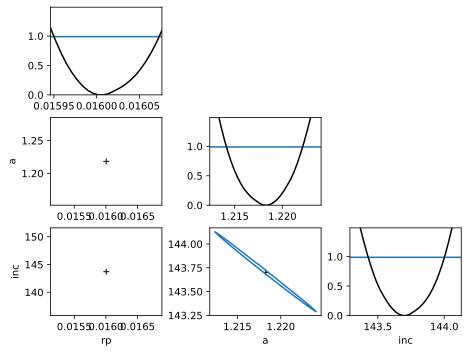

In [322]:
m.draw_mnmatrix();
plt.show()

In [188]:
params = [p for p in m.parameters]
print("Parameters (value ± 1σ):")
for p in params:
    print(f" {p}: {m.values[p]:.6g} ± {m.errors[p]:.6g}")
chi2 = m.fval
ndata = len(t); npar = len(params); dof = max(1, ndata - npar)
print(f"chi2 = {chi2:.3f}, dof = {dof}, reduced chi2 = {chi2/dof:.3f}")
print("Minuit state:")
print(m)

Parameters (value ± 1σ):
 rp: 0.016005 ± 4.50497e-05
 a: 1.21828 ± 0.00158194
 inc: 143.701 ± 0.112201
chi2 = 6117.522, dof = 1283, reduced chi2 = 4.768
Minuit state:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6118                       │              Nfcn = 627              │
│ EDM = 1.83e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.     

In [196]:
tbl = NasaExoplanetArchive.query_object("Kepler-10 b", table="pscomppars")

print(tbl)

a   = tbl['pl_orbsmax'][0]     # Yarı büyük eksen (AU)
rp  = tbl['pl_rade'][0]        # Gezegen yarıçapı (Dünya yarıçapı)
inc = tbl['pl_orbincl'][0]     # Yörünge eğikliği (derece)

print(f"  a   = {a:.4f} ")
print(f"  rp  = {rp:.4f} ")
print(f"  inc = {inc:.2f}")

objectid   pl_name   pl_letter ... pl_ndispec       sky_coord      
                               ...                   deg,deg       
-------- ----------- --------- ... ---------- ---------------------
    3.42 Kepler-10 b         b ...          0 285.679298,50.2414842
  a   = 0.0169 
  rp  = 1.4700 earthRad 
  inc = 84.80 deg


In [189]:
m.fixed = False
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6118                       │             Nfcn = 8288              │
│ EDM = 1.32e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ rp   │ 16.01e-3  │  0.05e-3  │            │            │    0    │    1    │       │
│ 1 │ a    │  1.2183   │  0.0016   │            │            │    0    │  1000   │       │
│ 2 │ inc  │  143.70   │   0.11    │            │            │    0    │   360   │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬───────────────────────────────┐
│     │        rp         a       inc │
├─────┼───────────────────────────────┤
│  rp │  2.03e-09  -17.0e-9 1.5937e-6 │
│   a │  -17.0e-9   2.5e-06 -176.5e-6 │
│ inc │ 1.5937e-6 -176.5e-6    0.0126 │
└─────┴───────────────────────────────┘

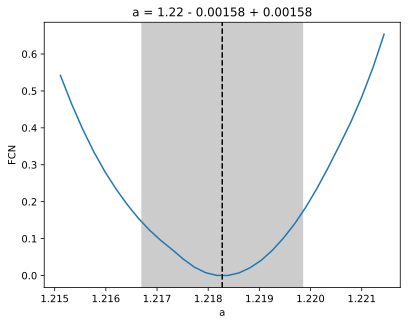

In [190]:
m.draw_mnprofile("a");

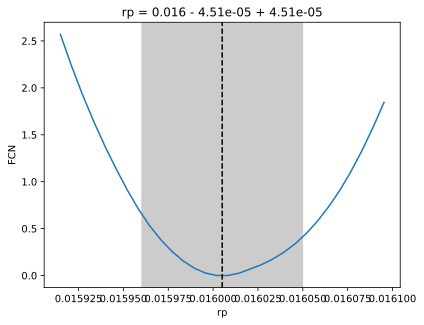

In [191]:
m.draw_mnprofile("rp");

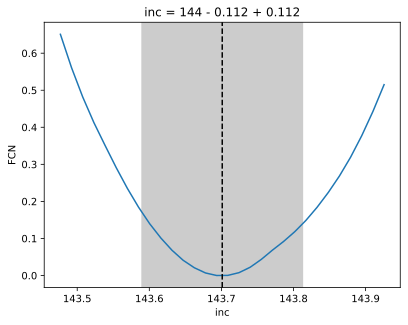

In [192]:
m.draw_mnprofile("inc");

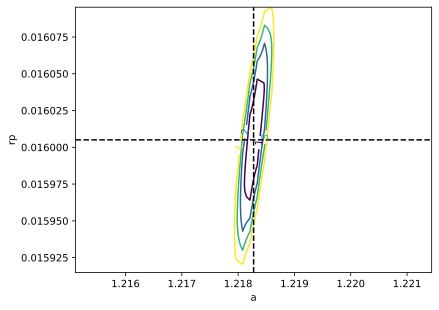

In [193]:
m.draw_contour("a", "rp");

E MnContours unable to find point on Contour 42 
 found only 41 points
E MnContours unable to find point on Contour 38 
 found only 37 points
E MnContours unable to find point on Contour 23 
 found only 22 points


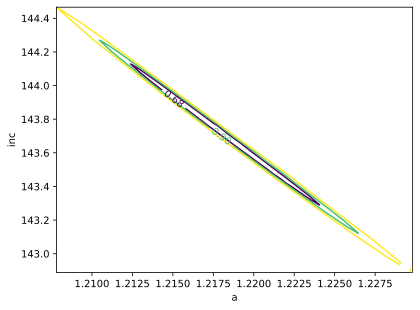

In [194]:
m.draw_mncontour("a", "inc", cl=(0.68, 0.9, 0.99));

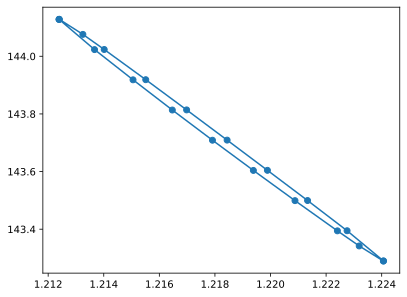

In [195]:
pts = m.mncontour("a", "inc", cl=0.68, size=20)
x, y = np.transpose(pts)
plt.plot(x, y, "o-");

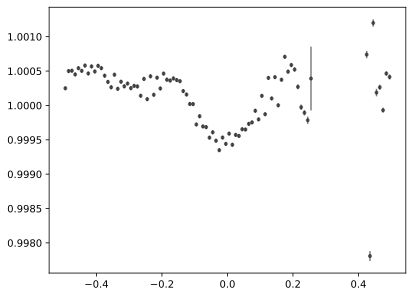

In [144]:
df_tess = pd.read_csv("D:\\Kodlar\\Kepler-10_b\\folded_lightcurve_tess.csv")

df_tess["time"] = pd.to_timedelta(df_tess["time"])
phase = df_tess["time"].dt.total_seconds().values / 86400  # zaman (gün)
flux = df_tess["flux"].astype(float).values
flux_err = df_tess["flux_err"].astype(float).values
t0 = 2454964.57375
t_norm = phase - t0
plt.errorbar(phase, flux, yerr=flux_err, fmt='.', color="black", alpha=0.5, label=' Tess Data')
plt.show()

In [160]:
def transit_model_tess(phase, rp, a, inc):
    params = batman.TransitParams()
    params.t0 = 0.
    params.per = 0.8375  # Kepler-10b için değer
    params.rp = rp
    params.a = a
    params.inc = inc
    params.ecc = 0.
    params.w = 90.
    params.limb_dark = "quadratic"
    params.u = [0.3, 0.1] 
    #params.limb_dark = "nonlinear"        #limb darkening model
    #params.u = [0.5, 0.1, 0.1, -0.1]
    
    m = batman.TransitModel(params, phase, fac=0.0025) 
    return m.light_curve(params)

In [161]:
best_model = transit_model(phase, *m.values)

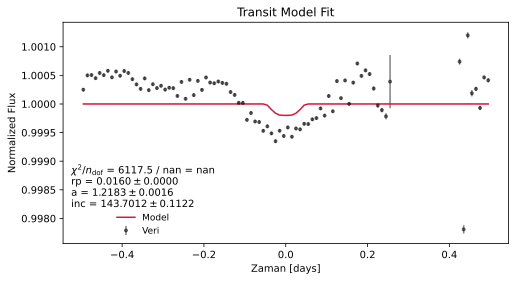

In [162]:
plt.figure(figsize=(8, 4))
plt.errorbar(phase, flux, yerr=flux_err, fmt='.', color="black", alpha=0.5, label='Veri')
plt.plot(phase, best_model, color='crimson', label='Model')

fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.4f} \\pm {e:.4f}$")

plt.legend(title="\n".join(fit_info), frameon=False, fontsize=9)

plt.xlabel("Zaman [days]")
plt.ylabel("Normalized Flux")
plt.title("Transit Model Fit")
plt.show()